Set up a fully trained network in the NTK regime. We have a 1-hidden layer ReLU network.

$$
f_{W, a} (x)  = \dfrac{1}{\sqrt{m}} \sum_{i=1}^m a_r \sigma(w_r^\intercal x)
$$

The parameters are initialized randomly:
$$
w_r(0) \sim \mathcal{N}(0, \kappa^2 \mathbb{I}), a_r \sim \text{unif}(\{-1, 1 \}), \forall r \in [m]
$$

We fix the second layer $\mathbf{a}$ and optimize the first layer $\bf{W}$ on the quadratic objective function.
$$
\phi(\mathbf{W}) = \dfrac{1}{2} \sum_{i=1}^n (y_i - f_{\mathbf{W, a (x_i)}})^2
$$

In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from estimator import classical_weights, V1_inspired_weights_same_center
from data_fns import load_mnist, load_cifar_10
from sklearn.model_selection import train_test_split

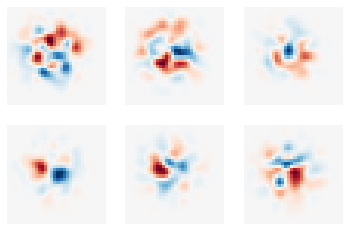

In [2]:
W = V1_inspired_weights_same_center(20, 1024, 5, 2, [14, 14])

fig = plt.figure()
for i in range(6):
    ax = fig.add_subplot(2, 3, i + 1)
    plt.imshow(W[i].reshape(32, 32), cmap='RdBu')
    plt.axis('off')
    cmap_lim = np.max(np.abs(W[i]))
    plt.clim(-cmap_lim, cmap_lim)

In [3]:
# load data
torch.cuda.set_device(0)
# train, train_labels, test, test_labels = load_mnist('./data/mnist/')
train, train_labels, test, test_labels = load_cifar_10(grayscale=True)

# convert data to tensors
train = torch.from_numpy(train).float().to('cuda')
train_labels = torch.from_numpy(train_labels).long().to('cuda')
test = torch.from_numpy(test).float().to('cuda')
test_labels = torch.from_numpy(test_labels).long().to('cuda')

# reshape
train_labels = train_labels.reshape(-1, 1)
test_labels = test_labels.reshape(-1, 1)

X_train, X_test, y_train, y_test = train, test, train_labels, test_labels

## Repeat similar experimental conditions as Du et. al. 2019. 
"Fine-Grained Analysis of Optimization and Generalization for Overparameterized Two-Layer Neural Networks "

In [5]:
# normalize inputs so that |x|_2 = 1
train /= torch.norm(train, dim=1).reshape(-1, 1)
test /= torch.norm(test, dim=1).reshape(-1, 1)

# load only the first two classes
train_idx = torch.logical_or(train_labels == 0, train_labels == 1).flatten()
test_idx = torch.logical_or(test_labels == 0, test_labels == 1).flatten()
train_binary = train[train_idx]

# We want label = 1 if first class and -1 otherwise.
# So we multiply original labels by -2 and add 1. Then, 0 -> 1, 1 -> -1
train_labels_binary = train_labels[train_idx] * -2 + 1
test_labels_binary = test_labels[test_idx] * -2 + 1

# We have 10k training samples and ~2k validation samples
X_test, y_test = test[test_idx], test_labels_binary
X_train, X_val, y_train, y_val = train_test_split(train_binary, train_labels_binary, train_size=9999, random_state=42)

In [6]:
# Set up the neural network. Hidden weights are trained but the output weights are fixed.
class NTK_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, kappa):
        super().__init__()
        self.hidden_size = hidden_size
        self.fc1 = nn.Linear(input_size, hidden_size)
        torch.nn.init.normal_(self.fc1.weight, mean=0, std=kappa ** 2)
        self.output = nn.Linear(hidden_size, output_size)
        torch.nn.init.uniform_(self.output.weight, a=-1, b=1)
        self.output.weight.requires_grad = False # freeze layer
        
    def forward(self, inputs):
        x = torch.relu(self.fc1(inputs))
        return 1 / np.sqrt(self.hidden_size) * self.output(x)

class bio_NTK_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, kappa):
        super().__init__()
        self.hidden_size = hidden_size
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc1.weight.data = torch.FloatTensor(V1_inspired_weights_same_center(hidden_size, input_size, t=5, l=2, m=[14, 14], 
                                                                                 scale=kappa ** 2))
        self.output = nn.Linear(hidden_size, output_size)
        torch.nn.init.uniform_(self.output.weight, a=-1, b=1)
        self.output.weight.requires_grad = False # freeze layer
        
    def forward(self, inputs):
        x = torch.relu(self.fc1(inputs))
        return 1 / np.sqrt(self.hidden_size) * self.output(x)

In [7]:
input_size, hidden_size, output_size, kappa = X_train.shape[1], 5000, 1, 1e-2
network = NTK_net(input_size, hidden_size, output_size, kappa).to('cuda')
bio_network = bio_NTK_net(input_size, hidden_size, output_size, kappa).to('cuda')

In [8]:
n_epochs, lr = 50000, 1e-3
loss_func = nn.MSELoss(reduction='sum')
loss_list = []
for i in range(n_epochs):
    optim = torch.optim.SGD(network.parameters(), lr=lr)
    optim.zero_grad()
    loss = loss_func(network(X_train), y_train.float()) / 2
    loss.backward()
    optim.step()
    loss_list.append(loss)
    if (i % 10000 == 0):
        print('Epoch: %d, loss=%0.3f' % (i, loss))

Epoch: 0, loss=5000.171
Epoch: 10000, loss=2543.427
Epoch: 20000, loss=2347.483
Epoch: 30000, loss=2186.552
Epoch: 40000, loss=2062.933


In [9]:
n_epochs, lr = 50000, 1e-3 
loss_func = nn.MSELoss(reduction='sum')
loss_list_bio = []
for i in range(n_epochs):
    optim = torch.optim.SGD(bio_network.parameters(), lr=lr)
    optim.zero_grad()
    loss = loss_func(bio_network(X_train), y_train.float()) / 2
    loss.backward()
    optim.step()
    loss_list_bio.append(loss)
    if (i % 5000 == 0):
        print('Epoch: %d, loss=%0.3f' % (i, loss))

Epoch: 0, loss=4997.392
Epoch: 5000, loss=2307.976
Epoch: 10000, loss=2077.646
Epoch: 15000, loss=1940.436
Epoch: 20000, loss=1838.689
Epoch: 25000, loss=1756.415
Epoch: 30000, loss=1686.695
Epoch: 35000, loss=1626.005
Epoch: 40000, loss=1572.135
Epoch: 45000, loss=1523.268


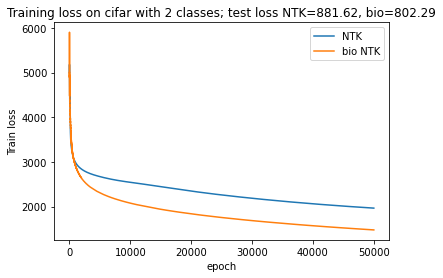

In [13]:
ntk_test_loss = loss_func(network(X_test), y_test)
bio_test_loss = loss_func(bio_network(X_test), y_test)
fig = plt.figure()
t = np.arange(1, n_epochs + 1)
plt.title('Training loss on cifar with 2 classes; test loss NTK=%0.2f, bio=%0.2f' % (ntk_test_loss, bio_test_loss))
plt.plot(t, loss_list, label='NTK')
plt.plot(t, loss_list_bio, label='bio NTK')
plt.xlabel('epoch')
plt.ylabel('Train loss')
plt.legend()
plt.savefig('results/NTK_analysis/cifar10_train_loss_h=%d_fixed_center.png' % hidden_size)

## kernel matrix analysis

In [126]:
from estimator import V1_inspired_kernel_matrix

In [127]:
t, l, m = 5, 2, [14, 14]
C = V1_inspired_kernel_matrix(input_size, t, l, m, scale=1 / input_size)
C = torch.from_numpy(C).float().to('cuda')

In [129]:
H_inf = (X_train @ X_train.T) * (np.pi - torch.acos(X_train @ X_train.T)) / np.pi 
H_inf[torch.isnan(H_inf)] = 0
H_inf_bio = (X_train @ X_train.T) * (np.pi - torch.acos(X_train @ C @ X_train.T)) / np.pi

In [134]:
eig_val, eig_vec = torch.symeig(H_inf, eigenvectors=True)
eig_val_bio, eig_vec_bio = torch.symeig(H_inf_bio, eigenvectors=True)

In [138]:
proj = eig_vec @ y_train.float()
proj_bio = eig_vec_bio @ y_train.float()

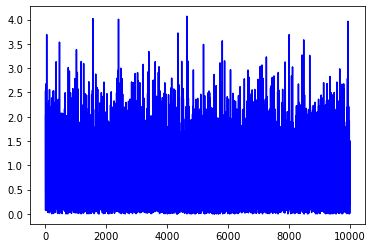

In [154]:
fig = plt.figure()
plt.plot(torch.abs(proj).cpu(), c='b')
# plt.plot(torch.abs(proj_bio).cpu(), c='r')

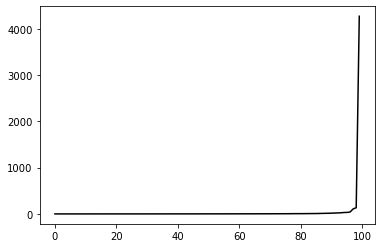

In [152]:
fig = plt.figure()
# plt.plot(eig_val.cpu()[-100:], c='b')
plt.plot(eig_val_bio.cpu()[-100:], c='r')

In [139]:
eig_va

torch.Size([9999, 1])